# Libraries

In [1]:
#export
import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.data.all import *
from fastai.distributed import *
import pandas as pd
from pathlib import Path
import time
from datetime import date
from vidaug import augmentors as va

import torchvision.transforms as T


from modules_th.video_block import * 
from modules_th.inflator import *
from modules_th.triplet_loss import *
from modules_th.supcon_module import *
from modules_th.cus_cbs import *

#Pretrained models
from modules_th.pretrained_r2p1d50 import *
from resnetmodels.mean import get_mean_std

In [2]:
#export
def read_data():
    items_path = '/mnt/data/adrianlopez/Datasets/kinetics700/kinetics_train.csv'
    return pd.read_csv(items_path, index_col=0)

In [3]:
df = read_data()
df.head(9)

,vid_files,label,val
0,/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Byron School of Clay students throwing on the pottery wheel.mp4,clay pottery making,False
1,/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Carcoar Pottery turning a mug on a Pottery wheel.mp4,clay pottery making,False
2,/mnt/data/adrianlopez/Datasets/kinetics700/Videos/How to make clay pottery for kids - part 2.mp4,clay pottery making,False
3,/mnt/data/adrianlopez/Datasets/kinetics700/Videos/How to move just made pottery to a board.mp4,clay pottery making,False
4,/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Tiny salt pig making.mp4,clay pottery making,False
5,/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Centering On The Potters Wheel.mp4,clay pottery making,False
6,/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Wheel throwing 6 kilo Waterfilters in 4 minutes by Bill Powell.mp4,clay pottery making,False
7,/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Lattice Pottery.mp4,clay pottery making,True
8,/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Cade Throwing.mp4,clay pottery making,False


In [30]:
df = read_data()
df = df.sample(frac=0.01)

In [14]:
pip= [ColReader('vid_files'),ColReader('label')]
dset = Datasets(df, pipTrue
)

In [16]:
dset[0]

('/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Paint spraying.mp4',
 'spraying')

In [5]:
# export
def sometimes(x):
    return va.Sometimes(0.5,x)
    
def wrapVideo(x):
    return Video(x)

In [19]:
#export
def get_dsets(df, l=40, size=512,skip=20,n_views=2):
    
    vid_pip = [ ColReader('vid_files'),
                createVideoForm(l=l,skip=skip, form='img'), 
               Resize(size, method=ResizeMethod.Pad),
               sometimes(va.HorizontalFlip()),
               va.GaussianBlur(1.),
#               sometimes(va.InvertColor()),
               va.RandomRotate(10),
               wrapVideo]

    lbl_pip = [ColReader('label'), Categorize()]           
    pip = [*([vid_pip]*n_views), lbl_pip]
    #splits
    splits = ColSplitter('val')(df)

    # Datasets and dataloaders
    dsets = Datasets(df, pip, splits=splits)
    return dsets, splits

In [ ]:
ColSplitter('val')(df)

((#90) [0,1,2,3,4,5,6,7,11,12...], (#43) [8,9,10,19,23,26,29,37,41,46...])

In [20]:
dsets,splits = get_dsets(df)
vid = dsets[0][0]

In [23]:
dsets[0]

((#40) [<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37E8FAC0>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37E8FB20>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37E8F8B0>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37E8F8E0>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37E8FA30>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37E8FB50>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37E8F7F0>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37E8F850>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37E8F940>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37E8F7C0>...],
 (#40) [<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37801310>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD378013D0>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37801370>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD37801580>,<PIL.Image.Image image mode=RGB size=512x512 at 0x7EFD378017F0>,<PIL.Image.Image im

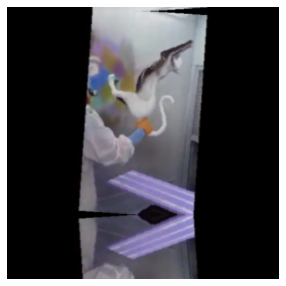

In [21]:
vid.show()

In [26]:
# export
def get_dls(dsets,splits,df, n_el= 2, n_lbl = 2, shuffle_fn= UniformizedShuffle, normalize='kinetics'):
        
    mean, std = get_mean_std(1,normalize)
    dls  = dsets.dataloaders(bs=n_el*n_lbl, 
                             shuffle_train=True,
                             after_item=ToTensor(),
                             after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)])
    
    dls.valid.shuffle = True
    if shuffle_fn is not None:
        dls.train.shuffle_fn = UniformizedShuffle(df.label.iloc[splits[0]], n_el = n_el, n_lbl= n_lbl)
        dls.valid.shuffle_fn = UniformizedShuffle(df.label.iloc[splits[1]], n_el = n_el, n_lbl= n_lbl)
    return dls
    True


In [27]:
dls = get_dls(dsets,splits,df, normalize='kinetics')


In [28]:
#export
def setup_log(learn,name, append=True):
     # set up logs file
    # now = datetime.now()
    # time = now.strftimes("%d_%m")
    logs_file = '/mnt/data/eugeniomarinelli/UCF_experiments/training_results/logs_kinetics_'+name+'.csv'
    Logs_csv =   CSVLogger(fname= logs_file, append=append)    
    learn.add_cb(Logs_csv)

In [ ]:
True


In [30]:
#export
def get_learner(df,
                pretrained_model='r2p1d50_K',  
                loss_name='CEL', 
                l=40, size=224, n_lbl =2, n_el=2, skip=20, embs_size=256,n_views=2, 
                normalize = 'kinetics'):

    dsets,splits = get_dsets(df, l, size, skip, n_views)

    dls = get_dls(dsets,splits,df, normalize=normalize)
    
    if pretrained_model in inserted_models:
        model = inserted_models[pretrained_model]
    else: raise 'model not present in pretrained models'
   

    body = create_body(model, cut=-2)
        


    if loss_name == 'SCL+CEL':
        Loss = SumLoss(SupConLoss,p='cos', alpha=1, n_views=n_views)
        head = inflate(create_head(256, len(dls.vocab), lin_ftrs=[]))
        model = MixedLossModel(body,head)
        metrics = [supcon_accuracy, silh_score]
        
        
    elif loss_name == 'SCL':
        Loss= SupConLoss() 
        head = inflate(create_head(4096, embs_size, lin_ftrs=[]))
        model = nn.Sequential(body,head)
        metrics = [silh_score]
        
        
    elif loss_name == 'CEL':
        Loss = CEL()
        head = inflate(create_head(4096, len(dls.vocab), lin_ftrs=[256]))
        model = MixedLossModel(body,head)
        metrics = [supcon_accuracy,silh_score]
        
    elif loss_name == 'CEL_after_SCL':
        Loss = CrossEntropyLossFlat()
        saved_model = torch.load('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/models/r2p1d50_ucf101_SCL_tuned_15fr.pth')
        model = nn.Sequential(saved_model,nn.Sequential(nn.ReLU(inplace=True),LinBnDrop(256, 101, p=0.5)))
        metrics = [accuracy]
    else:
        raise 'Loss not implemented'

    
        
    learn = Learner(dls, 
                model,
                splitter=splitter ,
                loss_func=Loss,
                metrics=metrics)

    if loss_name == 'SCL+CEL':
        learn.add_cbs([ContrastiveCallback(n_views)])#,LossesRecorderCallback()])
    elif loss_name == 'SCL':
        learn.add_cb(ContrastiveCallback(n_views))
    elif loss_name in ['CEL', 'CEL_after_SC']:
        learn.add_cb(MultiViewsCallback(n_views))
    time = date.today().strftime("_%d-%m")
        
    setup_log(learn, str(pretrained_model)+'_'+loss_name+'_tuning_10_'+time, append=True)
   
    return learn
 

In [31]:
learn = get_learner(df, 'r2p1d50_K', loss_name='CEL_after_SCL', l=2, size=64, n_lbl =2, n_el=2, skip=20, embs_size=256, n_views=2)
#learn.add_cb(CSVLogger(fname='data/eugeniomarinelli/UCF_experiments/trained_models_cnn/learners/LOGGER_PROVA' , append=False)  )

loading pretrained model /mnt/data/eugeniomarinelli/pretrained/r2p1d50_K_200ep.pth


In [ ]:
from datetime import date
date.today().strftime("_%d-%m")

'_23-01'

In [ ]:
True
learn.fit_one_cycle(1)

In [ ]:
inp = torch.randn(8,3,30,100,100).cuda()
model = learn.model.cuda()
model(inp).shape

torch.Size([8, 101])

In [29]:
#export
def save_learner(learn, name):
    prefix = '/mnt/data/eugeniomarinelli/'
    try:
        learn.export(prefix+'UCF_experiments/trained_models_cnn/learners/learner_kinetics_'+name)
    except: print("learner export didn't work") 
    try:
        torch.save(learn.model,prefix+'UCF_experiments/trained_models_cnn/models/model_kinetics_'+name+'.pth')
    except: pass
    torch.save(learn.model.state_dict(),prefix+'UCF_experiments/trained_models_cnn/models/state_dict_kinetics_'+name)
    


In [32]:
# learn.export('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/learners/LEARNER_CANCELLARE')
save_learner(learn, 'CANCELLARE')

In [ ]:
b = torch.load('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/learners/learner_ucf101_XXXXXX.pth')

In [ ]:
saved_model_SCL = torch.load('/mnt/data/eugeniomarinelli/UCF_experiments/trained_models_cnn/models/r2p1d50_ucf101_SCL_tuned_15fr.pth')

In [ ]:

model = nn.Sequential(saved_model_SCL,nn.Sequential(nn.ReLU(inplace=True),LinBnDrop(256, 101, p=0.5)))


In [14]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_losses_tmp.ipynb.
Converted 02_inflator.ipynb.
Converted 03_video_block.ipynb.
Converted 05_charades.ipynb.
Converted 07_read_video_function.ipynb.
Converted 08_transformer.ipynb.
Converted 09_lr_schedule.ipynb.
Converted 10_experiments_on_images.ipynb.
Converted 11_create_embeddings.ipynb.
Converted 12_load_r2p1d_model.ipynb.
Converted CALTECH101_MixedLoss.ipynb.
Converted CALTECH101_singleloss.ipynb.
Converted Embeddings_CRIMES.ipynb.
Converted Embeddings_UCF101.ipynb.
Converted KINETICS.ipynb.
Converted UCF101.ipynb.
Converted UCF101_unsupervised.ipynb.
Converted UCF_Crimes_CEL.ipynb.
Converted UCF_Crimes_SupCon.ipynb.
Converted index.ipynb.


In [ ]:
#default_exp kinetics

In [7]:
import cv2

In [11]:
files = df.vid_files
corrupted = L()
for file in files:
    if os.path.exists(file):
        stat = os.stat(file)
        if stat.st_size < 50000:
            corrupted.append(str(file))
    else:
        print(f"{file} Not found")

In [12]:
corrupted

(#7) ['/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Fire.mp4','/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Fire.mp4','/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Fire.mp4','/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Fire.mp4','/mnt/data/adrianlopez/Datasets/kinetics700/Videos/My gum.mp4','/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Fire.mp4','/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Sledgehammer exercises.mp4']

In [16]:
cap = cv2.VideoCapture('/mnt/data/adrianlopez/Datasets/kinetics700/Videos/Watering.mp4')
duration = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print(duration)
cap.release()

1824.0
